# Multivariate Fuzzy C-means method: Implementation

## Equations

### $J= \sum_{i=1}^{c} \sum_{k=1}^{n} \sum_{j=1}^{p} \left(u_{ijk} \right)^{m} d_{ijk}$ - Objective function to minimize.

### $d_{ijk} = \left(x_{jk} - y_{ij} \right)^{2}$ - euclidian distance squared.

### $ y_{ij} = \frac{\sum_{k=1}^{n} \left(u_{ijk} \right)^{m} x_{jk}} {\sum_{k=1}^{n} \left(u_{ijk}\right)^{m}}$ - prototype coordinate of a given cluster in feature j.

### $ u_{ijk} =  \left[\sum_{h=1}^{c}\sum_{l=1}^{p} \left(\frac{d_{ijk}}{d_{hlk}}\right)^{(1/(m-1))}  \right]^{-1} $ - membership degree of pattern k in cluster $C_{i}$ on the feature j.

### $\delta_{ik} = \sum_{j=1}^{p} u_{ijk}$ - represents an aggregation measure for all the p features.

## Constraints:

### - $u_{ijk} \in [0, 1]$ for all i, j and k;
### - $0 < \sum_{j=1}^{p} \sum_{k=1}^{n} u_{ijk} < n$ for all i and
### - $\sum_{i=1}^{c}\sum_{j=1}^{p}u_{ijk} = 1$ for all k.

## Importando bibliotecas

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Tratamento dos dados

In [3]:
def gerar_configuracao(mu_list, sigma_list, tamanhos, config_id):
    dfs = []
    for i, (mu, sigma2, n) in enumerate(zip(mu_list, sigma_list, tamanhos)):
        Sigma = np.diag(sigma2)
        data = np.random.multivariate_normal(mu, Sigma, n)
        df = pd.DataFrame(data, columns=["x1", "x2"])
        df["class"] = i + 1
        dfs.append(df)
    df_config = pd.concat(dfs, ignore_index=True)
    df_config["config"] = config_id
    return df_config

np.random.seed(42)  # reprodutibilidade

# -------------------------------
# Configuração 1
mu_1 = [[5, 0], [15, 5], [18, 14]]
sigma2_1 = [[81, 9], [9, 100], [25, 36]]
n1 = [200, 100, 50]
df1 = gerar_configuracao(mu_1, sigma2_1, n1, config_id=1)
l1 = "Classes elípticas de tamanhos diferentes"

# -------------------------------
# Configuração 2
mu_2 = [[0, 0], [30, 0], [12, 25]]
sigma2_2 = [[100, 100], [49, 49], [16, 16]]
n2 = [200, 100, 50]
df2 = gerar_configuracao(mu_2, sigma2_2, n2, config_id=2)
l2 = "Classes esféricas de tamanhos diferentes"

# -------------------------------
# Configuração 3
mu_3 = [[0, 0], [15, 5], [15, -5]]
sigma2_3 = [[100, 4], [100, 4], [100, 4]]
n3 = [100, 100, 100]
df3 = gerar_configuracao(mu_3, sigma2_3, n3, config_id=3)
l3 = "Classes elípticas de tamanhos iguais"

# -------------------------------
# Configuração 4
mu_4 = [[0, 0], [15, 0], [-15, 0]]
sigma2_4 = [[16, 16], [16, 16], [16, 16]]
n4 = [100, 100, 100]
df4 = gerar_configuracao(mu_4, sigma2_4, n4, config_id=4)
l4 = "Classes elípticas de tamanhos iguais"

# -------------------------------
# Configuração 5
mu_5 = [[5, 0], [15, 5], [10, -7], [3, 15]]
sigma2_5 = [[81, 9], [9, 100], [49, 16], [25, 25]]
n5 = [50, 50, 50, 50]
df5 = gerar_configuracao(mu_5, sigma2_5, n5, config_id=5)
l5 = "3 classes elípticas e 1 esférica"

# -------------------------------
# Configuração 6
mu_6 = [[5, 0], [15, 5], [12, -12], [7, 17]]
sigma2_6 = [[81, 9], [9, 100], [16, 16], [25, 25]]
n6 = [50, 50, 50, 50]
df6 = gerar_configuracao(mu_6, sigma2_6, n6, config_id=6)
l6 = "2 classes elípticas e 2 esféricas"

# -------------------------------
# Configuração 7
mu_7 = [[0, 0], [18, 0], [-18, 0], [0, -12]]
sigma2_7 = [[12, 12], [20, 20], [16, 16], [81, 20]]
n7 = [50, 50, 50, 50]
df7 = gerar_configuracao(mu_7, sigma2_7, n7, config_id=7)
l7 = "1 classe elíptica e 3 esféricas"

In [4]:
class MFCM():
    def __init__(self, c, X, m):
        self.c = c
        self.n = X.shape[0]
        self.p = X.shape[1]
        self.m = m
    
    def initialize_u(self):
        return np.random.dirichlet(alpha=np.ones(self.c * self.p),
                                   size=self.n).reshape(self.n, self.c, self.p)
    
    def find_centroides(self, X, U):
        return np.sum((U ** self.m) * X[:, np.newaxis, :], axis=0) / np.sum(U ** self.m, axis=0)
    
    def get_distances(self, X, V): # as vezes tem umas distâncias muito pequenas
        return (X[:, np.newaxis, :] - V[np.newaxis, :, :]) ** 2
    
    def update_u(self, D):
        ratio = (D[:, np.newaxis, np.newaxis, :, :] / D[:, :, :, np.newaxis, np.newaxis]) ** (1/(self.m-1))
        return 1 / (np.sum(ratio, axis=(3, 4)))
    
    def get_objective_function(self, U, D):
        return np.sum((U ** self.m)*D)
    
def mfcm_run(dados, num_clusters, m=2, max_iter=10**3, epsilon=1e-5):
    mfcm = MFCM(c=num_clusters, X=dados, m=m) # create the MFCM object
    
    U = mfcm.initialize_u() # initialize the membership matrix
    
    for _ in range(max_iter):
        centroids = mfcm.find_centroides(dados, U)
        D = mfcm.get_distances(dados, centroids)
        new_U = mfcm.update_u(D)
        if np.linalg.norm(U - new_U) < epsilon:
            break
        U = new_U
    
    Delta = np.sum(U, axis=2)  # summing over the second axis (variables `j`)
    
    return centroids, U, Delta

def monte_carlo_mfcm_simulation(dados, labels, num_clusters, num_trials):
    results = []
    total_attempts = 0 # Safety counter to prevent infinite loops
    
    # Loop UNTIL the results list has the desired number of trials
    while len(results) < num_trials:
        total_attempts += 1
        
        # Run the MFCM algorithm once
        centroids, U, Delta = mfcm_run(dados, num_clusters)
        
        # Determine cluster assignment and calculate ARI
        predicted_labels = np.argmax(Delta, axis=1)
        ari = adjusted_rand_score(labels, predicted_labels)
        
        # Only if the result is good, add it to our list
        if ari > 0.01:
            results.append(ari)
        
        # Safety break: if it's taking too long, stop.
        # This avoids an infinite loop if the algorithm never converges well.
        if total_attempts > num_trials * 20:
             print(f"Warning: Stopped after {total_attempts} attempts. "
                   f"Only collected {len(results)}/{num_trials} results. "
                   "The algorithm may be struggling to find good solutions.")
             break

    # If no good results were found, return NaNs to avoid errors
    if not results:
        return np.nan, np.nan, []

    mean_rand_index = np.mean(results)
    std_rand_index = np.std(results)
    
    print(f"Successfully collected {len(results)} trials after {total_attempts} total attempts.")
    return mean_rand_index, std_rand_index, results

In [5]:
np.random.seed(42)

i = 1
for df in [df1, df2, df3, df4, df5, df6, df7]:
    if i == 5 or i == 6 or i == 7:
        num_clusters = 4
    else:
        num_clusters = 3
    df.drop("config", axis=1, inplace=True)
    if i == 5 or i == 6 or i == 7:
        df["class"].replace({1: 0, 2: 1, 3: 2, 4: 3}, inplace=True)
    else: 
        df["class"].replace({1: 0, 2: 1, 3: 2}, inplace=True)
    labels = df["class"].values
    df.drop("class", axis=1, inplace=True)
    dados = df.to_numpy()
    num_trials = 100
    mean_rand_index, std_rand_index, results = monte_carlo_mfcm_simulation(dados, labels, num_clusters, num_trials)

    print(f"Monte Carlo MFCM Clustering Results for Config {i}")
    print(f"Mean Rand Index: {mean_rand_index:.4f}")
    print(f"Standard Deviation of Rand Index: {std_rand_index:.4f}")
    print(results)
    print("\n")
    i += 1

Successfully collected 100 trials after 125 total attempts.
Monte Carlo MFCM Clustering Results for Config 1
Mean Rand Index: 0.2583
Standard Deviation of Rand Index: 0.0776
[0.3072628287352358, 0.3072628287352358, 0.3002552302630624, 0.3072628287352358, 0.3072628287352358, 0.33582835819151746, 0.3072628287352358, 0.3002552302630624, 0.3072628287352358, 0.13483793005873076, 0.3072628287352358, 0.3072628287352358, 0.36151069468811825, 0.3002552302630624, 0.3072628287352358, 0.13483793005873076, 0.36151069468811825, 0.13483793005873076, 0.3072628287352358, 0.3072628287352358, 0.21335349071405643, 0.21335349071405643, 0.3072628287352358, 0.21335349071405643, 0.3072628287352358, 0.3072628287352358, 0.3072628287352358, 0.3072628287352358, 0.33582835819151746, 0.21335349071405643, 0.21335349071405643, 0.3072628287352358, 0.13483793005873076, 0.3072628287352358, 0.13483793005873076, 0.3072628287352358, 0.13483793005873076, 0.3072628287352358, 0.3072628287352358, 0.13483793005873076, 0.3615106

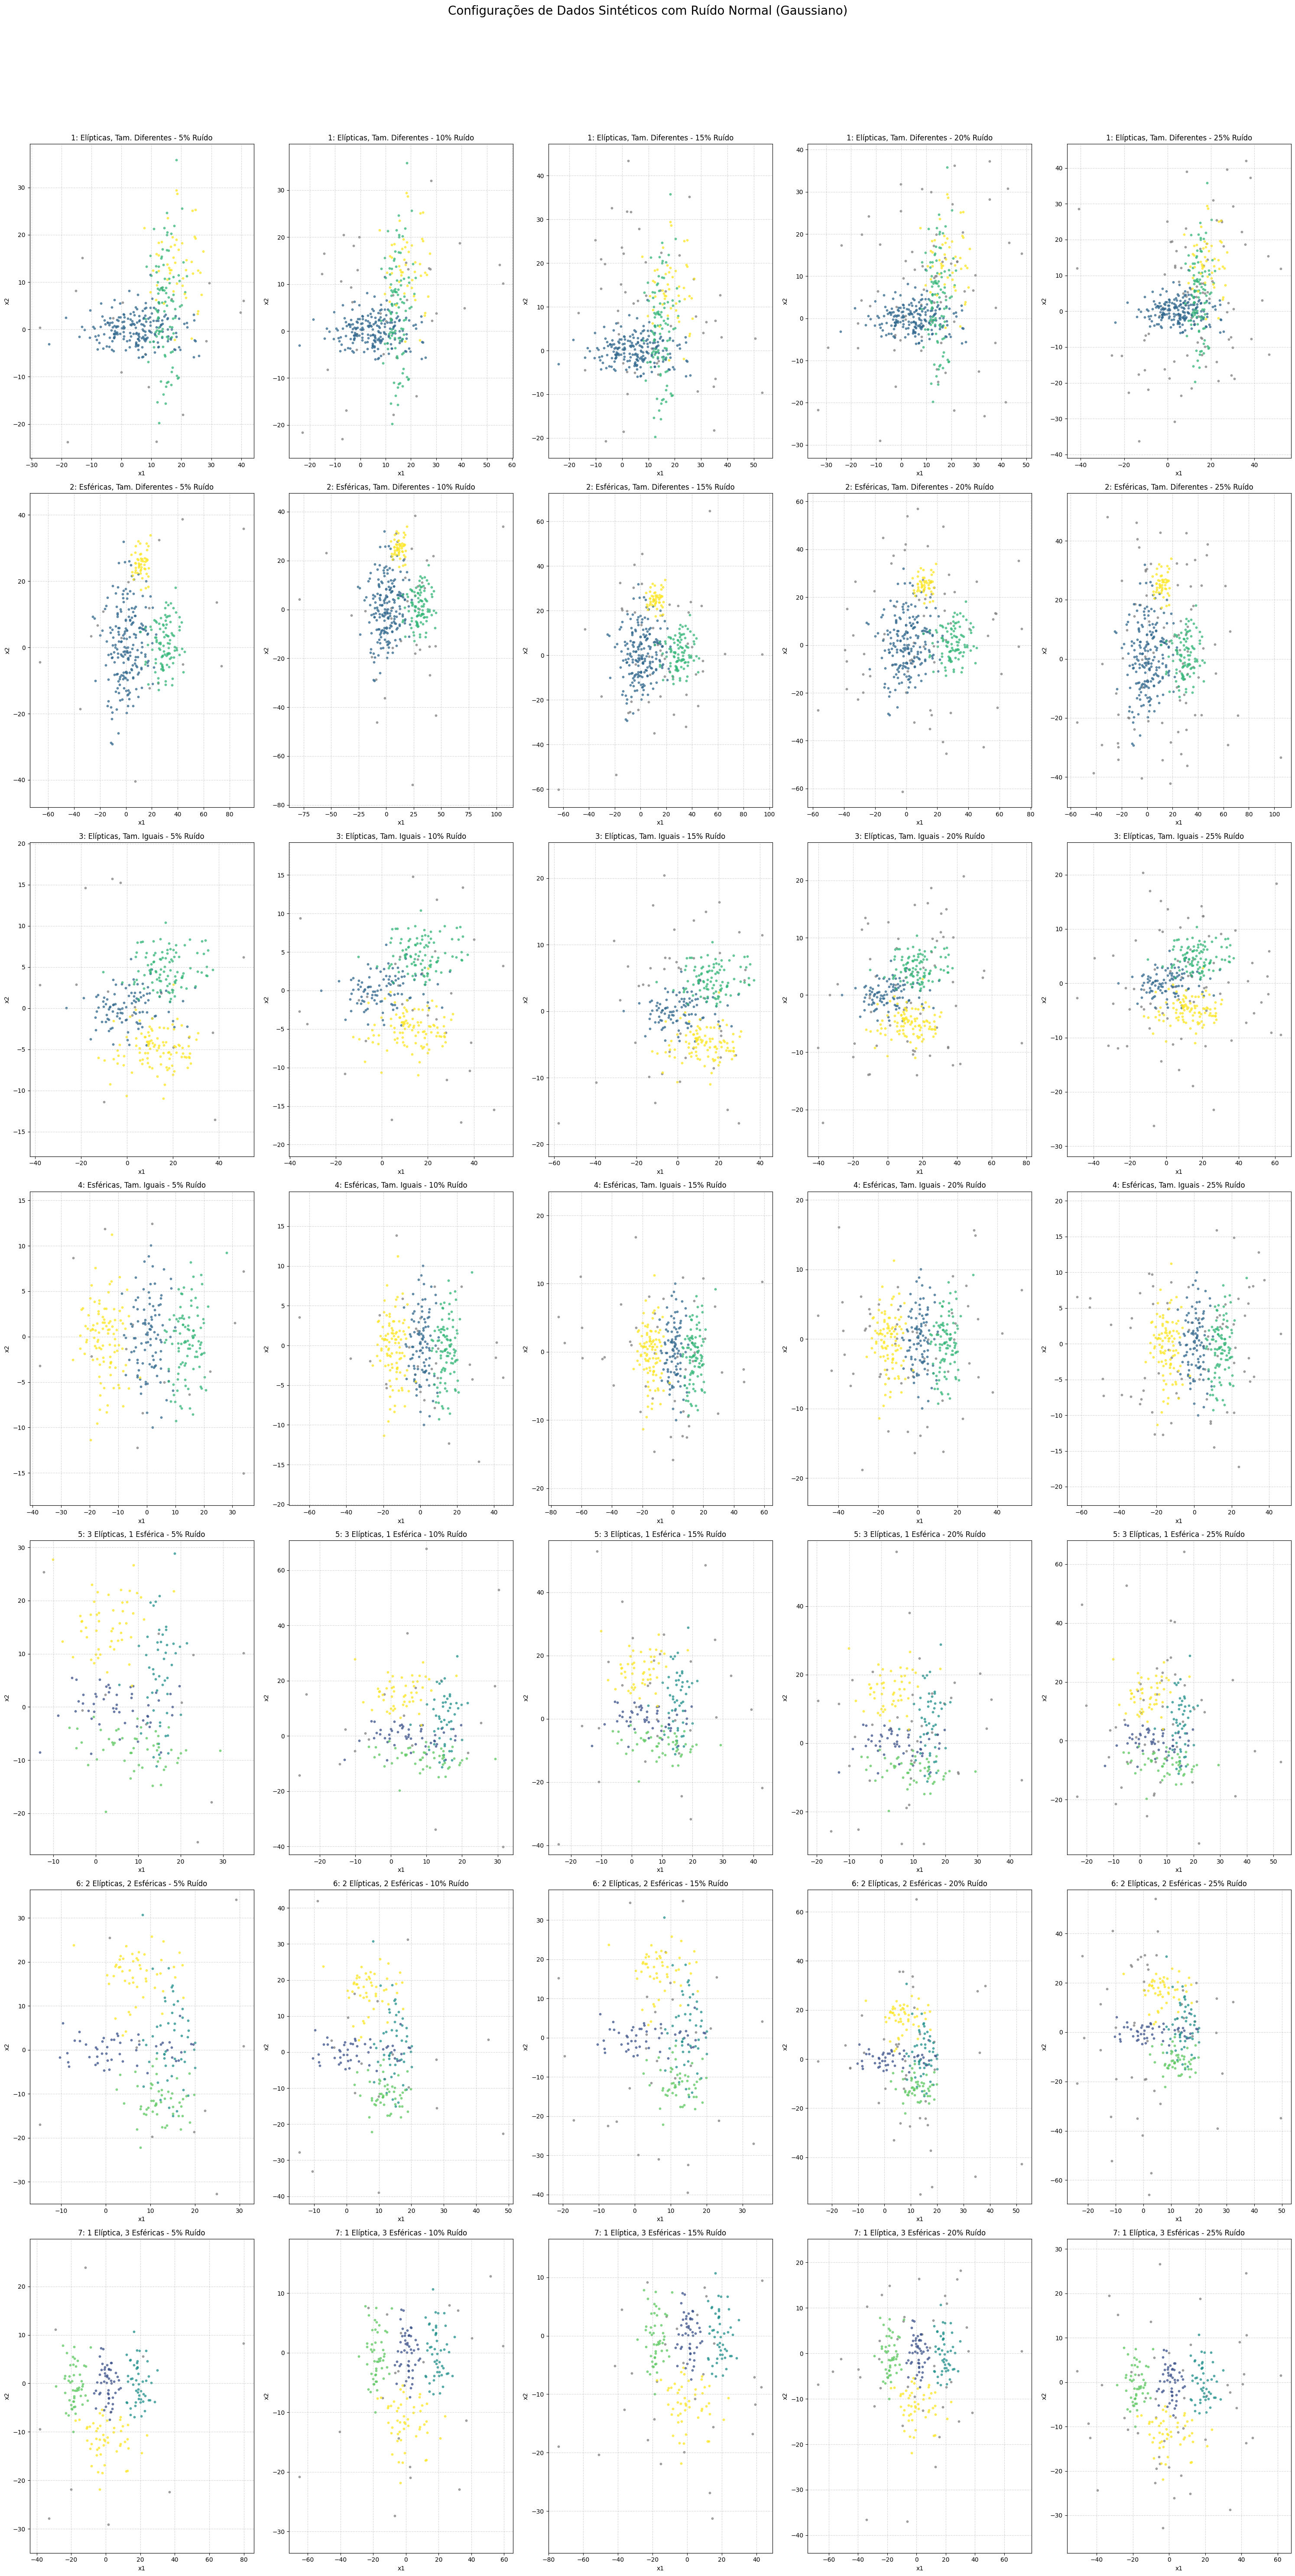

------------------------------
Configuração: 1, Ruído: 5%
Mean Rand Index: 0.238
Standard Deviation of Rand Index: 0.059
------------------------------
Configuração: 1, Ruído: 10%
Mean Rand Index: 0.271
Standard Deviation of Rand Index: 0.066
------------------------------
Configuração: 1, Ruído: 15%
Mean Rand Index: 0.260
Standard Deviation of Rand Index: 0.095
------------------------------
Configuração: 1, Ruído: 20%
Mean Rand Index: 0.213
Standard Deviation of Rand Index: 0.052
------------------------------
Configuração: 1, Ruído: 25%
Mean Rand Index: 0.215
Standard Deviation of Rand Index: 0.054
------------------------------
Configuração: 2, Ruído: 5%
Mean Rand Index: 0.481
Standard Deviation of Rand Index: 0.130
------------------------------
Configuração: 2, Ruído: 10%
Mean Rand Index: 0.393
Standard Deviation of Rand Index: 0.098
------------------------------
Configuração: 2, Ruído: 15%
Mean Rand Index: 0.404
Standard Deviation of Rand Index: 0.116
--------------------------

In [8]:
def gerar_configuracao(mu_list, sigma_list, tamanhos, config_id):
    dfs = []
    for i, (mu, sigma2, n) in enumerate(zip(mu_list, sigma_list, tamanhos)):
        Sigma = np.diag(sigma2)
        data = np.random.multivariate_normal(mu, Sigma, n)
        df = pd.DataFrame(data, columns=["x1", "x2"])
        df["class"] = i + 1
        dfs.append(df)
    df_config = pd.concat(dfs, ignore_index=True)
    df_config["config"] = config_id
    return df_config

def adicionar_ruido(df_original: pd.DataFrame, 
                           porcentagem: float, 
                           media_ruido: tuple, 
                           std_ruido: tuple) -> pd.DataFrame:
    n_original = len(df_original)
    n_ruido = int(n_original * porcentagem)

    if n_ruido == 0:
        return df_original.copy()

    media_x1, media_x2 = media_ruido
    std_x1, std_x2 = std_ruido

    # --- ALTERAÇÃO PRINCIPAL AQUI ---
    # Troca np.random.uniform por np.random.normal
    ruido_x1 = np.random.normal(loc=media_x1, scale=std_x1, size=n_ruido)
    ruido_x2 = np.random.normal(loc=media_x2, scale=std_x2, size=n_ruido)
    # --- FIM DA ALTERAÇÃO ---

    df_ruido = pd.DataFrame({'x1': ruido_x1, 'x2': ruido_x2})
    # O rótulo 0 é uma boa prática para identificar o ruído como uma "classe" separada
    df_ruido['class'] = 0 
    df_ruido['config'] = df_original['config'].iloc[0]

    return pd.concat([df_original, df_ruido], ignore_index=True)


np.random.seed(42)

config_param = [
    {'mu': [[5, 0], [15, 5], [18, 14]], 'sigma2': [[81, 9], [9, 100], [25, 36]], 'n': [200, 100, 50], 'desc': "1: Elípticas, Tam. Diferentes"},
    {'mu': [[0, 0], [30, 0], [12, 25]], 'sigma2': [[100, 100], [49, 49], [16, 16]], 'n': [200, 100, 50], 'desc': "2: Esféricas, Tam. Diferentes"},
    {'mu': [[0, 0], [15, 5], [15, -5]], 'sigma2': [[100, 4], [100, 4], [100, 4]], 'n': [100, 100, 100], 'desc': "3: Elípticas, Tam. Iguais"},
    {'mu': [[0, 0], [15, 0], [-15, 0]], 'sigma2': [[16, 16], [16, 16], [16, 16]], 'n': [100, 100, 100], 'desc': "4: Esféricas, Tam. Iguais"},
    {'mu': [[5, 0], [15, 5], [10, -7], [3, 15]], 'sigma2': [[81, 9], [9, 100], [49, 16], [25, 25]], 'n': [50, 50, 50, 50], 'desc': "5: 3 Elípticas, 1 Esférica"},
    {'mu': [[5, 0], [15, 5], [12, -12], [7, 17]], 'sigma2': [[81, 9], [9, 100], [16, 16], [25, 25]], 'n': [50, 50, 50, 50], 'desc': "6: 2 Elípticas, 2 Esféricas"},
    {'mu': [[0, 0], [18, 0], [-18, 0], [0, -12]], 'sigma2': [[12, 12], [20, 20], [16, 16], [81, 20]], 'n': [50, 50, 50, 50], 'desc': "7: 1 Elíptica, 3 Esféricas"}
]

porcentagens_ruido = [0.05, 0.10, 0.15, 0.20, 0.25]

# --- ALTERAÇÃO 1: Remoção dos parâmetros da distribuição uniforme ---
# As variáveis ruido_min e ruido_max não são mais necessárias.
# ruido_min, ruido_max = -100, 50

dados_gerados = {}

fig, axes = plt.subplots(7, 5, figsize=(30, 60))
fig.suptitle('Configurações de Dados Sintéticos com Ruído Normal (Gaussiano)', fontsize=20, y=1.02)

for i, params in enumerate(config_param):
    config_id = i + 1
    df_base = gerar_configuracao(params['mu'], params['sigma2'], params['n'], config_id=config_id)
    dados_gerados[config_id] = {} 

    # --- ALTERAÇÃO 2: Cálculo dos parâmetros para o ruído normal ---
    # Para cada configuração, calculamos a média e o desvio padrão dos dados base.
    # Isso torna a geração de ruído adaptativa para cada dataset.
    media_x1 = df_base['x1'].mean()
    media_x2 = df_base['x2'].mean()
    # Multiplicamos o desvio padrão por um fator (ex: 1.5) para que a nuvem de ruído
    # seja um pouco mais espalhada que os dados principais, cobrindo bem a área.
    std_x1 = df_base['x1'].std() * 2
    std_x2 = df_base['x2'].std() * 2

    for j, p_ruido in enumerate(porcentagens_ruido):
        p_ruido_int = int(p_ruido * 100) 
        
        # --- ALTERAÇÃO 3: Substituição da chamada da função ---
        # Trocamos 'adicionar_ruido' pela nova função, passando os parâmetros corretos.
        df_ruidoso = adicionar_ruido(
            df_base, 
            p_ruido, 
            media_ruido=(media_x1, media_x2), 
            std_ruido=(std_x1, std_x2)
        )

        dados_gerados[config_id][p_ruido_int] = df_ruidoso

        ax = axes[i, j]
        cores = plt.cm.viridis(np.linspace(0, 1, len(df_ruidoso['class'].unique())))
        cor_map = {cls: cores[k] for k, cls in enumerate(sorted(df_ruidoso['class'].unique()))}
        cor_map[0] = 'gray'

        for cls in sorted(df_ruidoso['class'].unique()):
            df_subset = df_ruidoso[df_ruidoso['class'] == cls]
            ax.scatter(df_subset['x1'], df_subset['x2'],
                       label=f'Classe {cls}' if cls != 0 else 'Ruído',
                       color=cor_map[cls], s=10, alpha=0.7)

        # --- ALTERAÇÃO 4: Lógica para os limites do gráfico ---
        # Agora, definimos os limites com base no dataset final (com ruído)
        # para garantir que todos os pontos, incluindo o novo ruído, sejam visíveis.
        padding = (df_ruidoso['x1'].max() - df_ruidoso['x1'].min()) * 0.05 # 5% de preenchimento
        ax.set_xlim(df_ruidoso['x1'].min() - padding, df_ruidoso['x1'].max() + padding)
        ax.set_ylim(df_ruidoso['x2'].min() - padding, df_ruidoso['x2'].max() + padding)
        
        ax.set_title(f"{params['desc']} - {p_ruido_int}% Ruído")
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

for config in range(1, 8):
    for noise in [5, 10, 15,20,25]:
        df = dados_gerados[config][noise].copy()
        
        if "config" in df.columns:
            df.drop("config", axis=1, inplace=True) 
        
        labels = df["class"].values
        num_clusters = len(df[df['class'] != 0]['class'].unique())
        
        if "class" in df.columns:
            df.drop("class", axis=1, inplace=True)
            
        dados = df.to_numpy()
        num_trials = 100
        
        media_indice_rand, dp_indice_rand = monte_carlo_mfcm_simulation(dados, labels, num_clusters, num_trials)
        print("-" * 30)
        print(f"Configuração: {config}, Ruído: {noise}%")
        print(f"Mean Rand Index: {media_indice_rand:.3f}")
        print(f"Standard Deviation of Rand Index: {dp_indice_rand:.3f}")

In [12]:
np.random.seed(42)

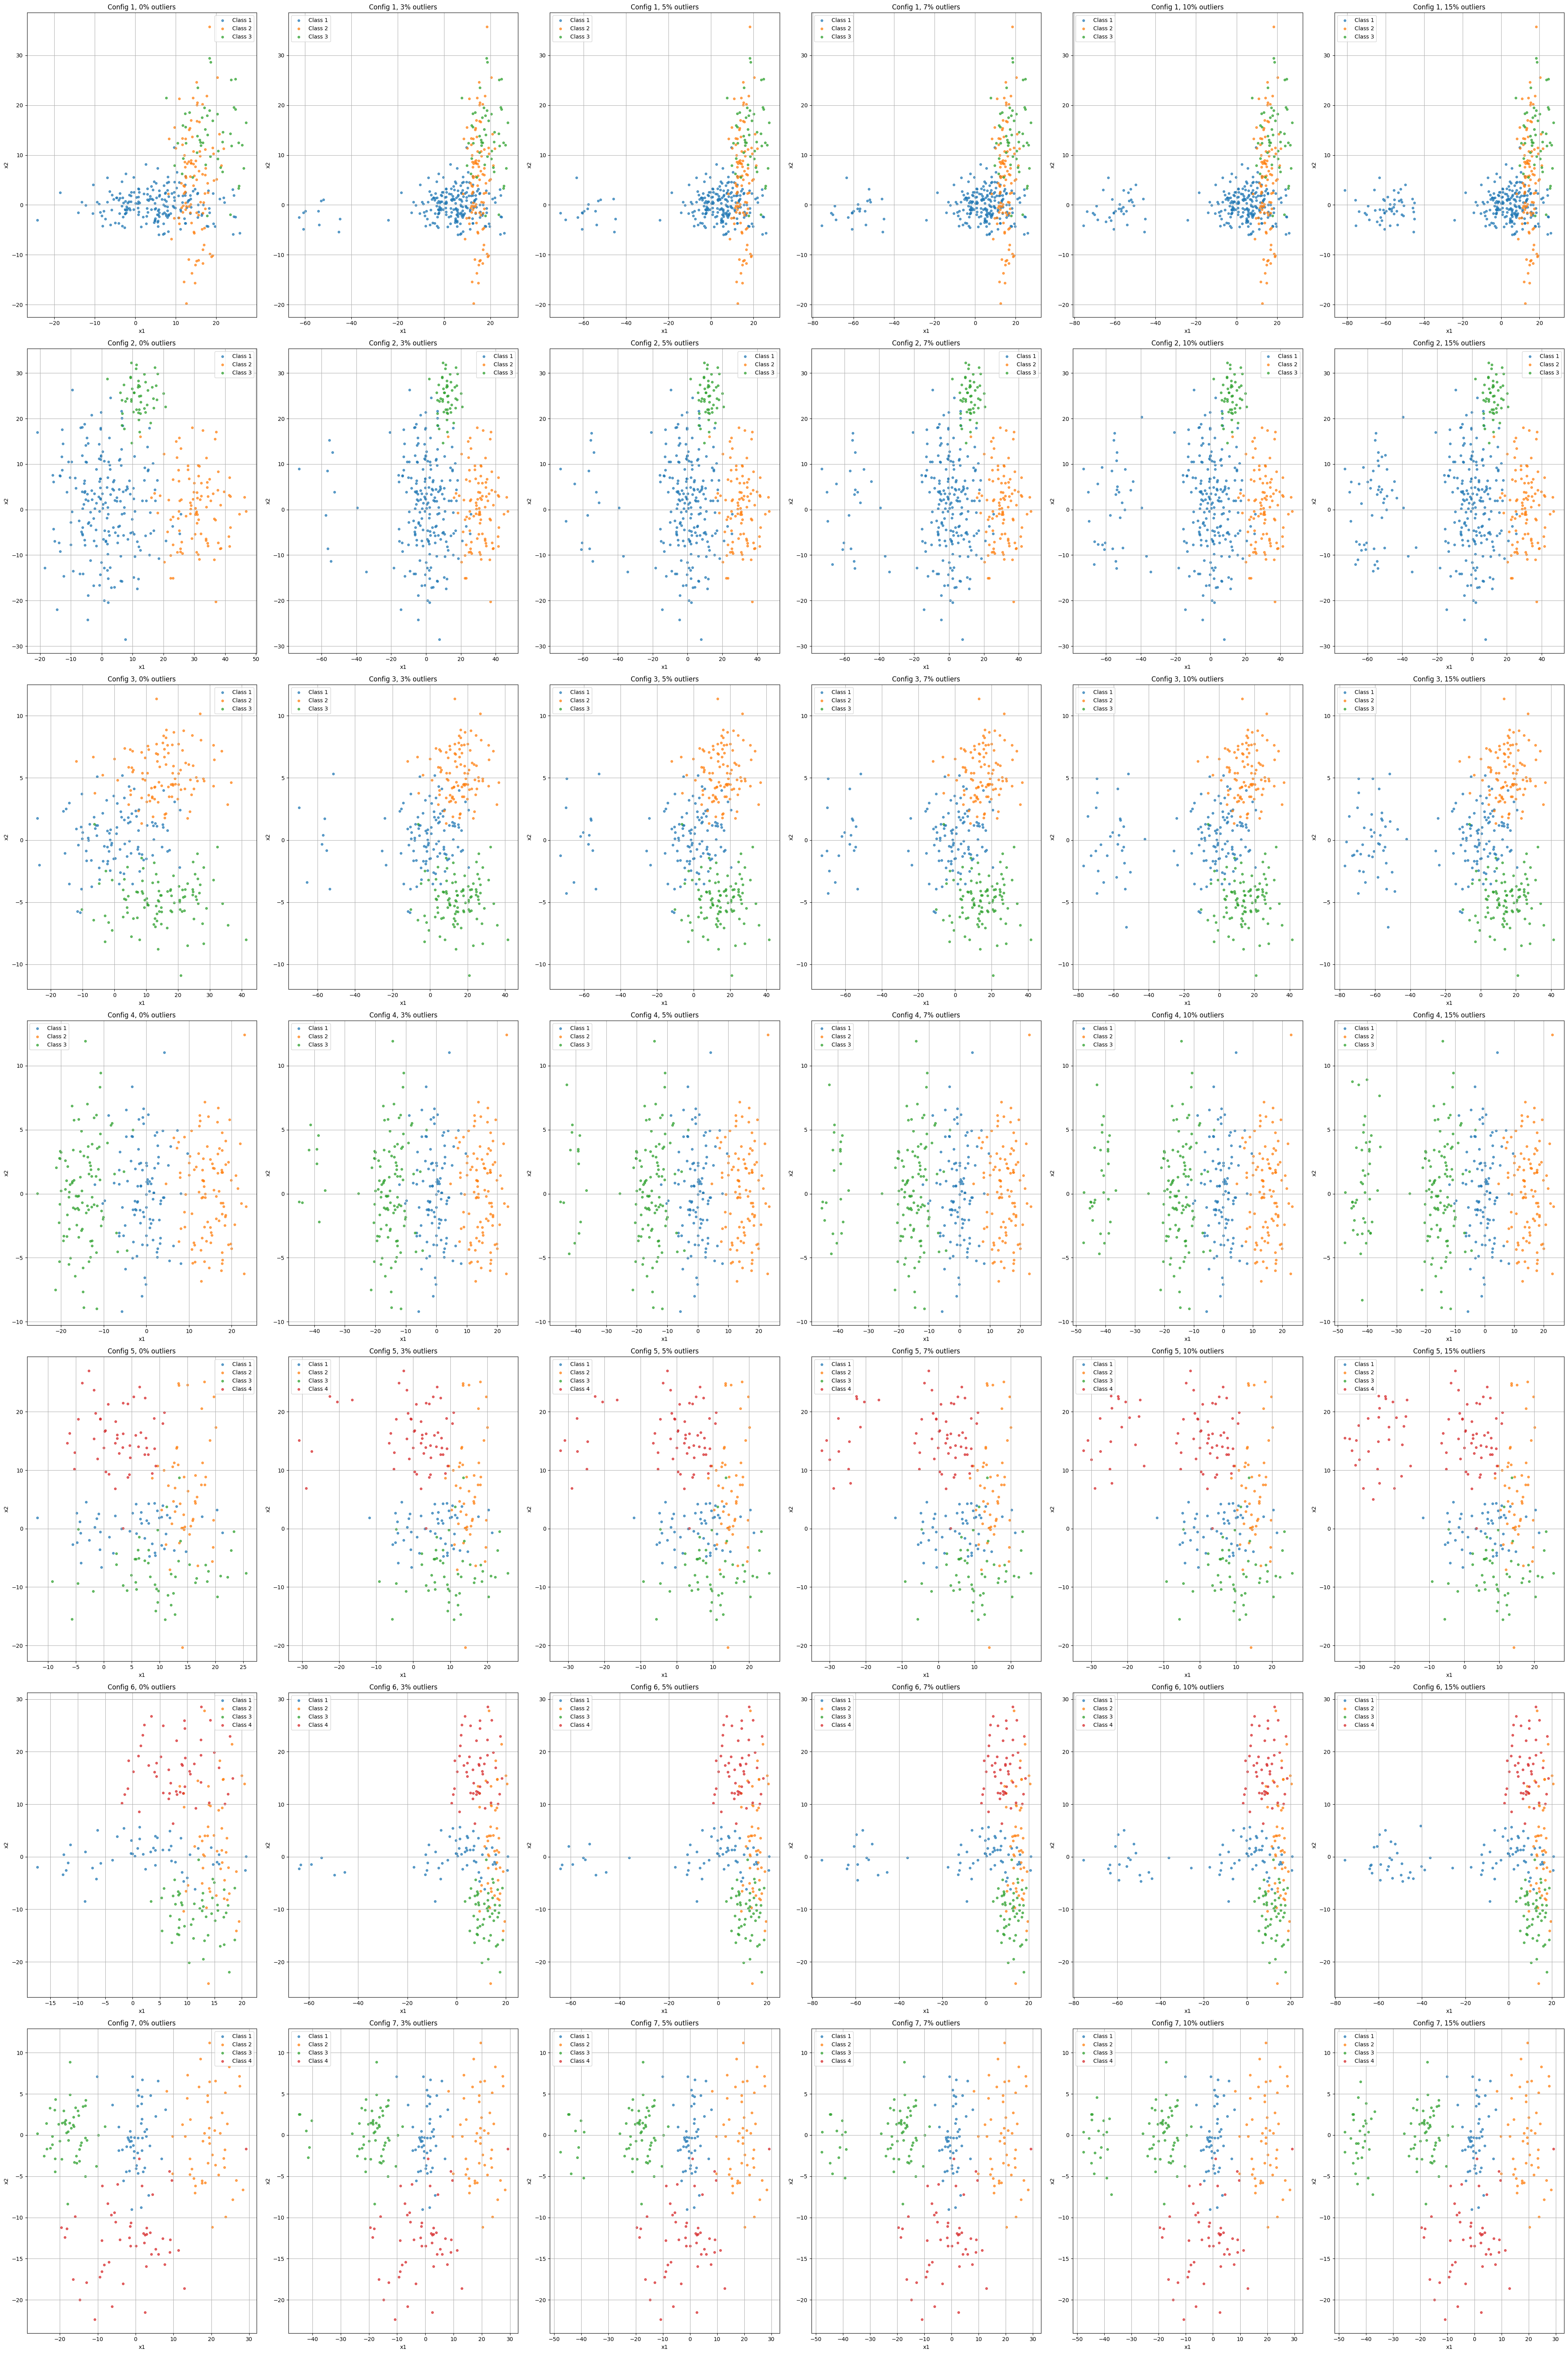

In [13]:
def adicionar_N_outliers_laterais(df_para_modificar: pd.DataFrame,
                                  df_original_referencia: pd.DataFrame,
                                  n_outliers_para_adicionar: int,
                                  cluster_id_alvo: int,
                                  multiplicador_std: float = 3.0) -> pd.DataFrame:
    
    if n_outliers_para_adicionar <= 0:
        return df_para_modificar.copy()
    
    dados_cluster_ref = df_original_referencia[df_original_referencia['class'] == cluster_id_alvo]
    
    std_x1_cluster = dados_cluster_ref['x1'].std()
    distancia_calculada = multiplicador_std * std_x1_cluster
    min_x1_cluster = dados_cluster_ref['x1'].min()
    centro_x1_outliers = min_x1_cluster - distancia_calculada

    std_x2_cluster = dados_cluster_ref['x2'].std()
    media_x2_cluster = dados_cluster_ref['x2'].mean()

    # Gera apenas o número N de novos outliers
    outliers_x1 = np.random.normal(loc=centro_x1_outliers, scale=std_x1_cluster, size=n_outliers_para_adicionar)
    outliers_x2 = np.random.normal(loc=media_x2_cluster, scale=std_x2_cluster, size=n_outliers_para_adicionar)

    df_novos_outliers = pd.DataFrame({'x1': outliers_x1, 'x2': outliers_x2})
    df_novos_outliers['class'] = cluster_id_alvo
    
    config_val = df_original_referencia['config'].iloc[0]
    df_novos_outliers['config'] = config_val
    
    # Concatena os novos outliers ao dataframe que já está sendo modificado
    df_final = pd.concat([df_para_modificar, df_novos_outliers], ignore_index=True)
    
    return df_final

lista_dfs_originais = [df1, df2, df3, df4, df5, df6, df7]

# 3. NOVA LÓGICA CUMULATIVA PARA ADICIONAR OUTLIERS

configuracoes_meta = [
    {'config_id': 1, 'outlier_target_cluster': 1},
    {'config_id': 2, 'outlier_target_cluster': 1},
    {'config_id': 3, 'outlier_target_cluster': 1},
    {'config_id': 4, 'outlier_target_cluster': 3},
    {'config_id': 5, 'outlier_target_cluster': 4},
    {'config_id': 6, 'outlier_target_cluster': 1},
    {'config_id': 7, 'outlier_target_cluster': 3}
]

# Garante que as porcentagens estão em ordem crescente
porcentagens_outlier = sorted([0, 0.03, 0.05, 0.07, 0.1, 0.15])

datasets_outliers = {}

for config_meta in configuracoes_meta:
    config_id = config_meta['config_id']
    df_original = lista_dfs_originais[config_id - 1]
    
    n_pontos_original = len(df_original)
    
    # df_acumulado guarda o resultado da etapa anterior
    df_acumulado = df_original.copy()
    datasets_outliers[(config_id, 0.0)] = df_acumulado

    
    # Itera sobre as porcentagens para calcular quantos outliers adicionar a cada passo
    for i in range(1, len(porcentagens_outlier)):
        p_atual = porcentagens_outlier[i]
        p_anterior = porcentagens_outlier[i-1]
        
        # Calcula o número total de outliers que deveríamos ter neste passo
        n_outliers_alvo = int(n_pontos_original * p_atual)
        
        # Calcula quantos outliers já existem no dataframe acumulado
        n_outliers_existentes = len(df_acumulado) - n_pontos_original
        
        # A diferença é o número de novos outliers a adicionar
        n_para_adicionar = n_outliers_alvo - n_outliers_existentes

        # Adiciona o número calculado de outliers ao dataframe já modificado
        df_acumulado = adicionar_N_outliers_laterais(
            df_para_modificar=df_acumulado,
            df_original_referencia=df_original, # Importante usar o original como referência
            n_outliers_para_adicionar=n_para_adicionar,
            cluster_id_alvo=config_meta['outlier_target_cluster'],
            multiplicador_std=4.0
        )
        datasets_outliers[(config_id, p_atual)] = df_acumulado


num_configs = len(configuracoes_meta)
num_outlier_porc = len(porcentagens_outlier)

fig, axes = plt.subplots(num_configs, num_outlier_porc, figsize=(40, 60), squeeze=False)

for i, config_meta in enumerate(configuracoes_meta):
    for j, percent_outliers in enumerate(porcentagens_outlier):
        ax = axes[i, j]
        config_id = config_meta['config_id']
        
        df_to_plot = datasets_outliers.get((config_id, percent_outliers))

        if df_to_plot is not None:
            for classe, dados_classe in df_to_plot.groupby('class'):
                ax.scatter(dados_classe['x1'], dados_classe['x2'], label=f'Class {classe}', s=15, alpha=0.7)
            
            ax.set_title(f'Config {config_id}, {int(percent_outliers*100)}% outliers')
            ax.set_xlabel('x1')
            ax.set_ylabel('x2')
            ax.legend()
            ax.grid(True)

plt.tight_layout()
plt.show()

In [14]:
np.random.seed(42)

for config in range(1, num_configs + 1):
    for outlier in porcentagens_outlier:
        df = datasets_outliers.get((config, outlier)).copy()
        df.drop("config", axis=1, inplace=True) 
        
        labels = df["class"].values
        num_clusters = len(df['class'].unique())
        
        df.drop("class", axis=1, inplace=True)
        
        dados = df.to_numpy()
        num_trials = 100
        media_indice_rand, dp_indice_rand = monte_carlo_mfcm_simulation(dados, labels, num_clusters, num_trials)
        print("-" * 30)
        print(f"Configuração: {config}, Outlier: {int(outlier * 100)}%")
        print(f"Mean Rand Index: {media_indice_rand:.3f}")
        print(f"Standard Deviation of Rand Index: {dp_indice_rand:.3f}")

------------------------------
Configuração: 1, Outlier: 0%
Mean Rand Index: 0.261
Standard Deviation of Rand Index: 0.077
------------------------------
Configuração: 1, Outlier: 3%
Mean Rand Index: 0.313
Standard Deviation of Rand Index: 0.005
------------------------------
Configuração: 1, Outlier: 5%
Mean Rand Index: 0.297
Standard Deviation of Rand Index: 0.005
------------------------------
Configuração: 1, Outlier: 7%
Mean Rand Index: 0.278
Standard Deviation of Rand Index: 0.003
------------------------------
Configuração: 1, Outlier: 10%
Mean Rand Index: 0.253
Standard Deviation of Rand Index: 0.004
------------------------------
Configuração: 1, Outlier: 15%
Mean Rand Index: 0.223
Standard Deviation of Rand Index: 0.007
------------------------------
Configuração: 2, Outlier: 0%
Mean Rand Index: 0.501
Standard Deviation of Rand Index: 0.158
------------------------------
Configuração: 2, Outlier: 3%
Mean Rand Index: 0.446
Standard Deviation of Rand Index: 0.145
--------------